# Train Handwriten digits classifier using PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from torch import nn, optim
from torchvision import datasets, transforms

from time import time

In [4]:
# move data and computation to GPU if avilable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on device:", device)

Training on device: cuda:0


In [ ]:
from torch.utils.tensorboard import SummaryWriter

#clear any logs from previous runs
!rm -rf ./runs/mnist_cnn_model

writer = SummaryWriter(log_dir='runs/mnist_cnn_model')

In [5]:
# turn PIL image into a 3D Torch tensor and normalize the pixel values from [0, 255] to [0, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [6]:
# Dataset as a subclass of torch.utils.data.Dataset
data_path = 'MNIST/processed/training.pt'

batch_size = 64

trainset = datasets.MNIST(root = data_path, download=True, train=True, transform=transform )
valset   = datasets.MNIST(root = data_path, download=True, train=False, transform=transform )

trainloader = torch.utils.data.DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True)
valloader   = torch.utils.data.DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

## Understand the data

In [7]:
print("number of taining images:", len(trainset))
print("number of validation images:", len(valset))
print("number of training images loaded per batch:", len(trainloader))
print("number of validation images loaded per batch:", len(valloader))

number of taining images: 60000
number of validation images: 10000
number of training images loaded per batch: 938
number of validation images loaded per batch: 157


In [8]:
# get training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [9]:
print('image data dims:', images.shape)
print('image label dim:', labels.shape)

image data dims: torch.Size([64, 1, 28, 28])
image label dim: torch.Size([64])


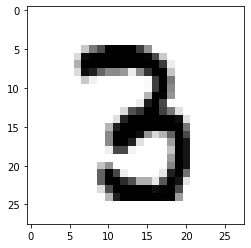

In [10]:
# display an image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

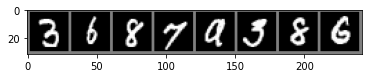

    3     6     8     7     9     3     8     6


In [11]:
#to display few images at a time, need apply the interse transform
def imshow(img):
    img = img/2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

num_images = 8    
imshow(torchvision.utils.make_grid(images[0:num_images]))
#display the image labels tensors as integer data type
print(' '.join('%5s' % labels.numpy()[j] for j in range(num_images)))

## Build the Neural Network

In [12]:
class Flatten(nn.Module):
    def forward(self, x):
        #reshape the tensor into a tensor with num_chanels * image_hight_out * image_width_out
        #columns and whatever number of rows stisfies that requirment 
        x = x.view(-1, 3*3*64)
        return x


model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      #nn.Dropout(0.5),
                      nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      #nn.Dropout(0.5),
                      nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      #nn.Dropout(0.5), 
                      Flatten(),
                      nn.Linear(3*3*64, 256),
                      nn.ReLU(),
                      #nn.Dropout(0.5),
                      nn.Linear(256, 10),
                      nn.LogSoftmax(dim=1))

# convert the parameters of all modules and buffers to CUDA tensor
model.to(device)
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=576, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)


### Define Loss Function and Optimizer

In [13]:
# Define the negative log-likelihood loss
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train the model

In [14]:
train_counter = []
train_loss = []
epoch_loss = []

epochs = 5

for epoch in range(epochs):  # loop over the dataset multiple times

    for batch_num, (images, labels) in enumerate(trainloader):

        # move images and labels to device
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize weights
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
        train_counter.append((batch_num + 1)*images.shape[0] + epoch * len(trainset))

    epoch_loss.append(train_loss[-1])
    
    writer.add_scalar('Train/Loss', epoch_loss[-1], epoch) #globsl_step = train_counter[-1]
    writer.flush()
        
    print("Epoch: {}, Loss {}".format(round(epoch, 4), round(epoch_loss[-1], 4)))
    
    print("Avg Trainig Loss: {}".format(sum(epoch_loss)/len(epoch_loss)))

Epoch: 0, Loss 0.4003
Avg Trainig Loss: 0.40034303069114685
Epoch: 1, Loss 0.0797
Avg Trainig Loss: 0.24001209437847137
Epoch: 2, Loss 0.0249
Avg Trainig Loss: 0.168308200314641
Epoch: 3, Loss 0.0462
Avg Trainig Loss: 0.13778607873246074
Epoch: 4, Loss 0.0647
Avg Trainig Loss: 0.12316363416612149


## Evaluate the model

In [16]:
correct = 0
total = 0

val_counter = []
val_loss = []

with torch.no_grad():
    for images, labels in valloader:
        
        # move images and labels to device
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        
        loss = loss_func(outputs, labels)
        
        total += labels.shape[0]
        correct += int((predicted ==labels).sum())
        
        val_loss.append(loss.item())
        
        # examine the performance of the model with the scalar metrics of loss, accuracy
        writer.add_scalar('Validation/Loss', val_loss[-1], len(val_loss))
        writer.add_scalar('Validation/Accuracy', val_accuracy, len(val_loss))
        writer.flush()
        
print("Number of images tested:", total)
print("\n Model Accuracy: {} %".format(100*correct/total)) 
print("\nAverage Validation loss: {}".format(round(sum(val_loss)/len(val_loss), 2)))

Number of images tested: 10000

 Model Accuracy: 98.31 %

Average Validation loss: 0.05


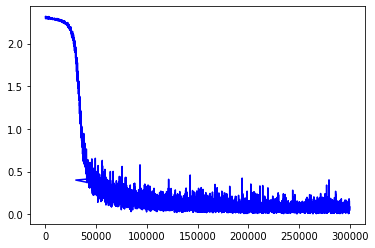

In [17]:
# Plot model training performance
plt.plot(train_counter, train_loss, color='blue')

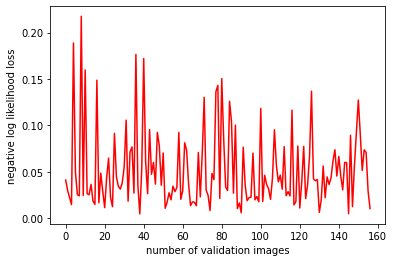

In [18]:
# Plot model validation performance
plt.plot(val_loss, color='red')
plt.xlabel('number of validation images')
plt.ylabel('negative log likelihood loss')
plt.show()

In [19]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10

train_losses = []
val_losses = []

for epoch in range(epochs):  

    for images, labels in trainloader:
        
        # zero the parameter gradients
        steps += 1
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval()
            
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in valloader:
                    
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, dim=1)
                    batch_loss = loss_func(outputs, labels)
                    total += labels.shape[0]
                    correct += int((predicted ==labels).sum())
                    val_loss += batch_loss.item()
                    accuracy += correct/total
                    
        
            loss = loss_func(outputs, labels)
        
            total += labels.shape[0]
            correct += int((predicted ==labels).sum())
            
            train_losses.append(running_loss/len(valloader))
            val_losses.append(val_loss/len(valloader))  
                
            print("Epoch {}, Training Loss {:.3f}, Validation Loss {:.3f}, Validation Accuracy {:.3f}".
                  format(epoch+1, running_loss/print_every, val_loss/len(valloader), accuracy/len(valloader))) 
                  
                  
            running_loss = 0
            model.train()

Epoch 1, Training Loss 0.047, Validation Loss 0.052, Validation Accuracy 0.981
Epoch 1, Training Loss 0.043, Validation Loss 0.059, Validation Accuracy 0.978
Epoch 1, Training Loss 0.074, Validation Loss 0.057, Validation Accuracy 0.977
Epoch 1, Training Loss 0.075, Validation Loss 0.057, Validation Accuracy 0.983
Epoch 1, Training Loss 0.083, Validation Loss 0.050, Validation Accuracy 0.983
Epoch 1, Training Loss 0.067, Validation Loss 0.057, Validation Accuracy 0.981
Epoch 1, Training Loss 0.070, Validation Loss 0.055, Validation Accuracy 0.984
Epoch 1, Training Loss 0.068, Validation Loss 0.054, Validation Accuracy 0.984
Epoch 1, Training Loss 0.058, Validation Loss 0.052, Validation Accuracy 0.983
Epoch 1, Training Loss 0.045, Validation Loss 0.054, Validation Accuracy 0.982
Epoch 1, Training Loss 0.035, Validation Loss 0.056, Validation Accuracy 0.982
Epoch 1, Training Loss 0.054, Validation Loss 0.056, Validation Accuracy 0.983
Epoch 1, Training Loss 0.036, Validation Loss 0.059,

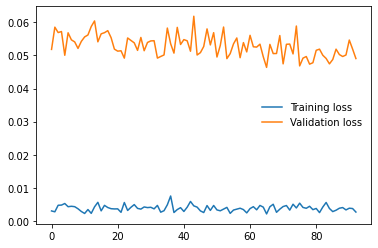

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Save the model for predictions

In [26]:
#save the model on GPU
torch.save(model.state_dict(), 'mnist_cnn_classifier.pth')

#load the model on GPU, with PyTorch overiding the device information when loading weights
#with map_location argument
device = torch.device("cuda:0")
loaded_model = model.to(device)
loaded_model.load_state_dict(torch.load('mnist_cnn_classifier.pth', map_location=device))

<All keys matched successfully>

## Use trained model for predictions

In [39]:
def classify(images, num_imgs):
    
    """ A function that predicts the class of a image in Pillow format."""
    
    with torch.no_grad():
        
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, dim=1)
        
        ps = torch.exp(outputs) # model output probabilities  as tensor
        # deal with numpy at the cpu
        proba = list(ps.cpu().numpy())
        #proba = list(ps.numpy()) # list of arrays
        
        pred_digits = []
        for i in range(len(proba)):
            
            pred_digits.append(proba[i].argmax())
        
        imshow(torchvision.utils.make_grid(images[0:num_imgs]))
        print(' '.join('%5s' % pred_digits[j] for j in range(num_imgs)))
        
    
    #return pred_digits

In [38]:
# get a random batch of validation images 
rand_sampler = torch.utils.data.RandomSampler(valset, num_samples=batch_size, replacement=True)
val_sampler = torch.utils.data.DataLoader(valset, batch_size=batch_size, sampler=rand_sampler)

dataiter = iter(val_sampler)

rand_batch_images, labels = dataiter.next()

rand_batch_images, labels = rand_batch_images.to(device), labels.to(device)

In [40]:
classify(rand_batch_images, num_imgs=5)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.